# Project : Amazon Fine Food Reviews.

In [1]:
# import the libarys

import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import re
import string
import os
import pickle

from sklearn.feature_extraction.text import TfidfTransformer , TfidfVectorizer , CountVectorizer

from sklearn.metrics import confusion_matrix , roc_curve

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec , KeyedVectors

from tqdm import tqdm

from bs4 import BeautifulSoup

### Read the file

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('G:/Software/Machine learning/Datasets/Amazon food review/database.sqlite') 

dataset_sqlite = pd.read_sql_query("""
                                    SELECT * FROM Reviews where Score != 3
                                    """ , con)

In [3]:
dataset_sqlite.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
np.unique(dataset_sqlite['Score'])

array([1, 2, 4, 5], dtype=int64)

In [5]:
amnt_1 = dataset_sqlite.Score.value_counts()[1]
amnt_2 = dataset_sqlite.Score.value_counts()[2]
amnt_4 = dataset_sqlite.Score.value_counts()[4]
amnt_5 = dataset_sqlite.Score.value_counts()[5]

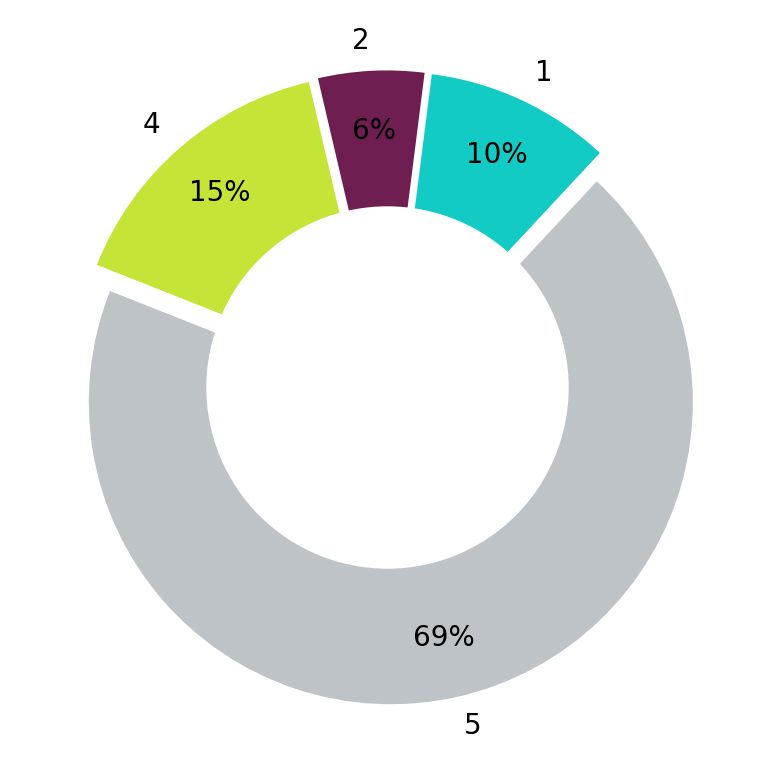

In [6]:
category_names = ['1', '2', '4', '5']
sizes = [amnt_1 , amnt_2 , amnt_4 ,  amnt_5]
custom_colours = ['#12CBC4', '#6F1E51', '#C4E538', '#bdc3c7']
offset = [0.05 , 0.05 , 0.05 , 0.05]


plt.figure(figsize = (12 , 10) , dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 20}, startangle=47, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

Most of the customer given 5 reviews on products.

In [7]:
# Convert the Reviews value into positive and negetive

def partition(x):
    if x < 3:
        return 'negetive'
    
    return 'positive'

In [8]:
actual_score = dataset_sqlite['Score']
positiveNegetive = actual_score.map(partition)
dataset_sqlite['Score'] = positiveNegetive

In [9]:
dataset_sqlite.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negetive,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negetive,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,positive,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,positive,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,positive,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,positive,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [10]:
dataset_sqlite.shape

(525814, 10)

In [11]:
dataset_sqlite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null object
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: int64(4), object(6)
memory usage: 40.1+ MB


In [12]:
dataset_sqlite.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [13]:
amnt_pos = dataset_sqlite.Score.value_counts()['positive']
amnt_neg = dataset_sqlite.Score.value_counts()['negetive']

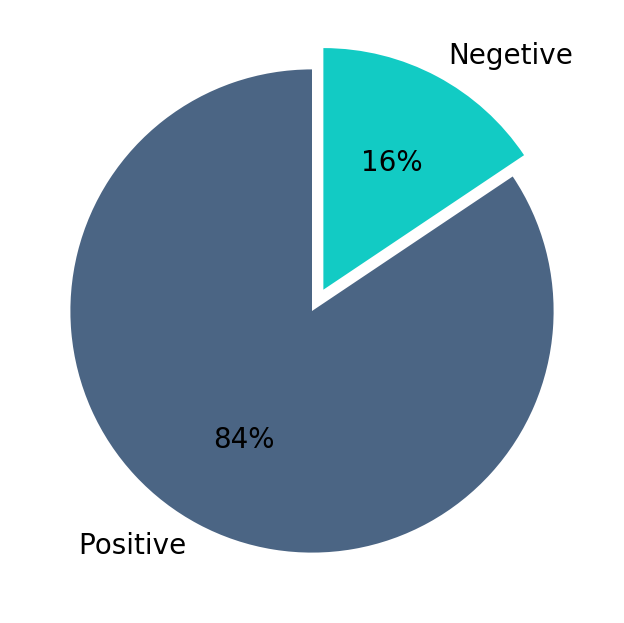

In [14]:
category_names = ['Positive' , 'Negetive']
sizes = [amnt_pos , amnt_neg]
custom_colours = ['#4b6584', '#12CBC4']

plt.figure(figsize = (10,8) , dpi=100)
plt.pie(sizes, labels=category_names , textprops={'fontsize': 20} , startangle = 90 , 
       autopct='%1.0f%%' , colors=custom_colours , explode=[0 , 0.1])

plt.show()

## Data Cleaning

In [15]:
display = pd.read_sql_query("""

                            select * from Reviews ORDER BY UserId
                            
                            """ , con)

display.head(15)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,136323,B006Q820X0,#oc-R103C0QSV1DF5E,C,1,2,5,1343088000,Great for the Price,I have to say I was a little apprehensive to b...
1,516062,B008I1XPKA,#oc-R109MU5OBBZ59U,AayGee,0,1,5,1350086400,AWESOME Coffee!!!!,Received my free K cups as a sample promotion ...
2,516079,B008I1XPKA,#oc-R10LFEMQEW6QGZ,Julie,0,1,5,1345939200,Brooklyn Bean Roastery Breakfast Blend K-Cups,Brooklyn Bean Roastery Blend K-Cups are great ...
3,378693,B0026LJ3EA,#oc-R10LT57ZGIB140,dipr,0,0,3,1310601600,Some damage,The shipment of the dog food was quick. Howev...
4,136545,B006Q820X0,#oc-R10UA029WVWIUI,Kim D,0,0,1,1342483200,Less than satisfactory. I gave the Brooklyn K...,"Brooklyn ""French Roast"" K-Cup Coffee is not on..."
5,83318,B005ZBZLT4,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
6,180872,B007Y59HVM,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
7,21719,B005DVVB9K,#oc-R119LM8D59ZW8Y,"Lee Mellott ""SEOmenu2go""",5,11,1,1320192000,Not So Sweet Treat!,I love chocolate so I was excited to see the C...
8,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
9,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


There have been many duplicates rows in the dataset.In the above table 8,9,10 rows have similar customer and he buy different product and review it at the same time.So it can be a garbage value.There can be some miscalculation when save it into the database.So it is necessasry to remove those rows for better performance.

In [16]:
display = pd.read_sql_query("""

                            select * from Reviews where Score !=3 and UserId="#oc-R11D9D7SHXIJB9" ORDER BY ProductID
                            
                            """ , con)

display.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
1,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
2,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


Check how many product the perticular customer but at a same time.


Check some other Users

In [17]:
display= pd.read_sql_query("""

                        select *
                        from Reviews
                        where Score != 3 AND UserId = "AR5J8UI46CURR"
                        ORDER BY ProductID
                        
                        """, con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


It is shown that this customer also have buy many different product at the same time and review it.This can be happen when a specific product have different color or differnet flavor.
So remove the duplicate all rows.

In [18]:
# Sorting the dataset according to productID

sorted_data = dataset_sqlite.sort_values(
                        'ProductId' , axis = 0 , ascending = True , inplace = False , kind = 'quicksort' ,  na_position='last'
                        )
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


Find the duplicates if the useid , profilename , time , text is the same then it is duplicate.And remove those rows.

In [19]:
#Deduplication of entries

final = sorted_data.drop_duplicates(subset = {'UserId' , 'ProfileName' , 'Time' , 'Text'} , keep = 'first' , inplace = False)
final.shape

(364173, 10)

In [20]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0) / (dataset_sqlite['Id'].size*1.0) * 100

69.25890143662969

After removing those duplicates rows we hvae 69% data remaining.

Another way to fina inconsistency in the dataset is if the <b>HelpfulnessNumerator</b> is greater than <b>HelpfulnessDenominator</b>

In [21]:
display= pd.read_sql_query("""

                        SELECT *
                        FROM Reviews
                        WHERE HelpfulnessNumerator > HelpfulnessDenominator
                        
                        """, con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [22]:
display= pd.read_sql_query("""

                        SELECT *
                        FROM Reviews
                        WHERE Score != 3 AND Id=44737 OR Id=64422
                        ORDER BY ProductID
                        
                        """, con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [23]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [24]:
final.shape

(364171, 10)

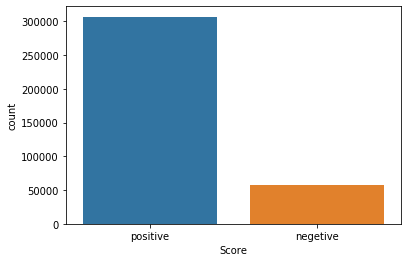

In [25]:
sns.countplot(x = 'Score' , data = final)

## Text Preprocessing

We already remove the duplicates values from the dataset.Now it's time to preprocess the dataset.There are many ways to clean or preprocess the dataset.


In [26]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)


sent_5000 = final['Text'].values[5000]
print(sent_5000)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [27]:
# remove urls from text python

sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)
sent_5000 = re.sub(r"http\S+" , "" , sent_5000)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [28]:
print(sent_4900)

Can't do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.<br /><br />Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.<br /><br />Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.<br /><br />I use this as my SWEETENER in baking: cheesecakes, white brownies, muffins, pumpkin pies, etc... Unbelievably delicious...<br /><br />Can you tell I like it? :)


In [29]:
## Beautiful Soup is a Python library for pulling data out of HTML and XML files

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)
print("="*50)


soup = BeautifulSoup(sent_5000 , 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [30]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [31]:
sent_4900

'Can\'t do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.<br /><br />Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.<br /><br />Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.<br /><br />I use this as my SWEETENER in baking: cheesecakes, white brownies, muffins, pumpkin pies, etc... Unbelievably delicious...<br /><br />Can you tell I like it? :)'

In [32]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
sent_4900 = decontracted(sent_4900)
print(sent_4900)

Ca not do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.<br /><br />Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.<br /><br />Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.<br /><br />I use this as my SWEETENER in baking: cheesecakes, white brownies, muffins, pumpkin pies, etc... Unbelievably delicious...<br /><br />Can you tell I like it? :)


In [34]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [35]:
# Remove words with numbers
sent_4900 = re.sub("\S*\d\S*" , "" , sent_4900).strip()
print(sent_4900)

Ca not do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.<br /><br />Thick, delicious.  Perfect.   ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.<br /><br />Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.<br /><br />I use this as my SWEETENER in baking: cheesecakes, white brownies, muffins, pumpkin pies, etc... Unbelievably delicious...<br /><br />Can you tell I like it? :)


In [36]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)

Ca not do sugar Have tried scores of SF Syrups NONE of them can touch the excellence of this product br br Thick delicious Perfect ingredients Water Maltitol Natural Maple Flavor PERIOD No chemicals No garbage br br Have numerous friends family members hooked on this stuff My husband son who do NOT like sugar free prefer this over major label regular syrup br br I use this as my SWEETENER in baking cheesecakes white brownies muffins pumpkin pies etc Unbelievably delicious br br Can you tell I like it 


In [37]:
%%time

preprocessed_review_text = []

for sentence in tqdm(final['Text'].values):
    
    sentence = re.sub('[^A-Za-z]+' , ' ' , sentence)
    sentence = re.sub('\S*\d\S*' , '' , sentence).strip()
    sentance = re.sub(r"http\S+", "", sentence)
    sentance = decontracted(sentance)
    sentence = BeautifulSoup(sentence , 'lxml').get_text()
    sentance = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    
    preprocessed_review_text.append(sentance.strip())

100%|██████████| 364171/364171 [03:14<00:00, 1867.82it/s]


Wall time: 3min 14s


In [38]:
preprocessed_review_text[6000]

'important fact follows searching item go immediately amazon amazed frazzled search replaced finding item quickly no wear tear nervous system end fruitless searches create much grief asking grocery stores help wasted many days waiting return call item stocked big mistake l b moss'

In [39]:
preprocessed_review_text[1000]

'really looking forward pods based reviews starbucks good prefer bolder taste imagine surprise ordered boxes expired one expired back gosh sakes admit amazon agreed credit cost plus part shipping geez years expired hoping find local san diego area shoppe carries pods try something different starbucks'

In [40]:
preprocessed_review_text[100]

'pros dog anything treat smell bad many treats easy break smaller pieces nothing artificial easy digestion cons costly dog treats overall great product expensive dog anything treat several phobias including getting car walking doorways ignores fears get treat'

In [41]:
preprocessed_review_text[0]

'witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college'

In [42]:
final['Text'][10]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

In [43]:
preprocessed_review_text[10]

'get movie sound track sing along carol king great stuff whole extended family knows songs heart quality kids storytelling music'

### Preprocess the Summary.

In [44]:
%%time

preprocessed_review_summary = []

for sentence in tqdm(final['Summary'].values):
    
    sentence = re.sub('[^A-Za-z]+' , ' ' , sentence)
    sentence = re.sub('\S*\d\S*' , '' , sentence).strip()
    sentance = re.sub(r"http\S+", "", sentence)
    sentance = decontracted(sentance)
    sentence = BeautifulSoup(sentence , 'lxml').get_text()
    sentance = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    
    preprocessed_review_summary.append(sentance.strip())

100%|██████████| 364171/364171 [01:56<00:00, 3132.03it/s]


Wall time: 1min 56s


In [45]:
preprocessed_review_summary[6000]

'best ever'

In [46]:
preprocessed_review_summary[600]

'happy hunter dfw'

## Bag of Words

In [47]:
final.shape

(364171, 10)

In [48]:
new_final = final
new_final.shape

(364171, 10)

Now we have only 10 columns.

Now convert those text to vector using Bag of words.

In [49]:
cnt = CountVectorizer()
final_counts = cnt.fit_transform(new_final['Text'].values)

In [50]:
final_counts.shape

(364171, 115281)

In [51]:
final_counts

<364171x115281 sparse matrix of type '<class 'numpy.int64'>'
	with 19341760 stored elements in Compressed Sparse Row format>

In [52]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [53]:
count_vect = CountVectorizer()
count_vect.fit(preprocessed_review_text)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa']


In [54]:
final_counts = count_vect.transform(preprocessed_review_text)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 106568)
the number of unique words  106568


## Bi-grams & n-grams

In [55]:
new_final.shape

(364171, 10)

In [56]:
#count_vect = CountVectorizer(ngram_range = (1,2) , min_df=10 , max_features = 5000)
count_vect = CountVectorizer(ngram_range = (1,2) , min_df=10)
final_bigram_counts = count_vect.fit_transform(preprocessed_review_text)

In [57]:
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 209009)
the number of unique words including both unigrams and bigrams  209009


In [58]:
final_bigram_counts

<364171x209009 sparse matrix of type '<class 'numpy.int64'>'
	with 19555112 stored elements in Compressed Sparse Row format>

In [59]:
# without doing any preprocess the text

count_vect = CountVectorizer(ngram_range = (1,2) , min_df = 10)
final_bigram_counts = count_vect.fit_transform(final['Text'].values)

In [60]:
final_bigram_counts.get_shape()

(364171, 254644)

### Without apply any stopwords.

In [61]:
%%time

preprocessed_review_text_noStop = []

for sentence in tqdm(final['Text'].values):
    
    sentence = re.sub('[^A-Za-z]+' , ' ' , sentence)
    sentence = re.sub('\S*\d\S*' , '' , sentence).strip()
    sentance = re.sub(r"http\S+", "", sentence)
    sentance = decontracted(sentance)
    sentence = BeautifulSoup(sentence , 'lxml').get_text()
    sentance = ' '.join(e.lower() for e in sentence.split())
    
    preprocessed_review_text_noStop.append(sentance.strip())

100%|██████████| 364171/364171 [03:18<00:00, 1831.57it/s]


Wall time: 3min 18s


In [62]:
preprocessed_review_text_noStop[4900]

'can t do sugar have tried scores of sf syrups none of them can touch the excellence of this product br br thick delicious perfect ingredients water maltitol natural maple flavor period no chemicals no garbage br br have numerous friends family members hooked on this stuff my husband son who do not like sugar free prefer this over major label regular syrup br br i use this as my sweetener in baking cheesecakes white brownies muffins pumpkin pies etc unbelievably delicious br br can you tell i like it'

In [63]:
count_vect = CountVectorizer(ngram_range = (1,2) , min_df = 10)
final_bigram_counts_noStop = count_vect.fit_transform(preprocessed_review_text_noStop)

In [64]:
final_bigram_counts_noStop.get_shape()

(364171, 251660)